In [1]:
import os
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


 

In [2]:
def preprocess_image(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    resized_image = cv2.resize(gray_image, (64, 64))
    return resized_image

In [3]:
def read_and_split_data(directory_path, test_size=0.2, val_size=0.2):
    data = []
    labels = []
    i = 0
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    for root, dirs, files in os.walk(directory_path):
        for dir in dirs:
            current_dir_path = os.path.join(root, dir)
            image_files = [f for f in os.listdir(current_dir_path) if f.endswith(".jpg") or f.endswith(".png")]
            
            for file in image_files:
                image_path = os.path.join(current_dir_path, file)
                image = cv2.imread(image_path)

                if image is not None:
                    faces = face_cascade.detectMultiScale(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY), 1.1, 4)

                    for (x, y, w, h) in faces:
                        face_img = image[y:y+h, x:x+w]
                    
                        face_img = preprocess_image(face_img)
                        data.append(face_img)
                        labels.append(dir)
                    
                        
                        
            
    data = np.array(data)
    labels = np.array(labels)

    # Görüntülerin boyutunu düzenleme (örnek sayısı, yükseklik, genişlik, kanal sayısı)
    # Gri tonlamalı görüntüler için kanal sayısı 1'dir
    data = data.reshape(data.shape[0], 64, 64, 1)
    
    # Normalize etme (0 ile 1 arasında)
    data = data / 255.0
    
    # Etiketleri integer'a dönüştürme (eğer gerekliyse)
    # Bu adım, etiketlerinizi sayısal bir formata çevirmeniz gerekiyorsa önemlidir.
    # Örneğin, `LabelEncoder` kullanabilirsiniz. Bu kısmı etiketlerinizin durumuna göre uyarlayın.
    
    # Veriyi eğitim ve test setlerine ayırma
    X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=test_size, random_state=42)
    
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_size, random_state=42)
    
    return X_train, X_val, X_test, y_train, y_val, y_test,data,labels

# Eğitim ve test setlerine ayırma

In [5]:
X_train, X_val, X_test, y_train, y_val, y_test,data,labels = read_and_split_data("105_classes_pins_dataset", test_size=0.2)

# Etiketleri sayısal formata dönüştürme

In [19]:
label_encoder= LabelEncoder()

y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

y_train_encoded = to_categorical(y_train_encoded, num_classes=105)
y_val_encoded = to_categorical(y_val_encoded, num_classes=105)
y_test_encoded = to_categorical(y_test_encoded, num_classes=105)

In [20]:
import pickle
from sklearn.preprocessing import LabelEncoder

# label_encoder'ı bir dosyaya kaydet
with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)

In [21]:
from tensorflow.keras.metrics import Precision, Recall
import tensorflow as tf
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = Precision()
        self.recall = Recall()
        
    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)
        
    def result(self):
        p = self.precision.result()
        r = self.recall.result()
        return 2 * ((p * r) / (p + r + tf.keras.backend.epsilon()))
        
    def reset_states(self):
        self.precision.reset_states()
        self.recall.reset_states()

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall
model = Sequential([
    # İlk evrişim katmanı
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 1)),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.25),


    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.25),
    
   
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.25),
    

    Flatten(),
    BatchNormalization(),
    
    
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.45),
    
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.45),
    
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.50),
    
    Dense(105, activation='softmax')  
])
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy',Precision(), Recall(), F1Score()])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 62, 62, 32)        320       
                                                                 
 batch_normalization_14 (Ba  (None, 62, 62, 32)        128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 31, 31, 32)        0         
 g2D)                                                            
                                                                 
 dropout_12 (Dropout)        (None, 31, 31, 32)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 batch_normalization_15 (Ba  (None, 29, 29, 64)       

In [23]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss', # İzlenecek metrik
    patience=10, # Metrikte iyileşme olmaması durumunda beklenilecek epoch sayısı
    verbose=1, # Eğitimin durdurulduğuna dair bilgilendirme mesajı
    restore_best_weights=True # En iyi ağırlıkların geri yüklenip yüklenmeyeceği
)

In [24]:
history = model.fit(X_train, y_train_encoded, epochs=150, validation_data=(X_val, y_val_encoded), batch_size=64,callbacks=[early_stopping])

Epoch 1/150


157/158 [============================>.] - ETA: 0s - loss: 5.6173 - accuracy: 0.0093 - precision_4: 0.0180 - recall_4: 1.9904e-04 - f1_score: 3.9374e-04

c:\Users\gorkem.ecer\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:2723: UserWarning: Metric F1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()


158/158 [==============================] - 12s 64ms/step - loss: 5.6181 - accuracy: 0.0092 - precision_4: 0.0180 - recall_4: 1.9855e-04 - f1_score: 3.9277e-04 - val_loss: 4.8504 - val_accuracy: 0.0123 - val_precision_4: 0.0000e+00 - val_recall_4: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 2/150
158/158 [==============================] - 10s 60ms/step - loss: 5.4281 - accuracy: 0.0113 - precision_4: 0.0083 - recall_4: 9.9275e-05 - f1_score: 1.9621e-04 - val_loss: 4.9386 - val_accuracy: 0.0103 - val_precision_4: 0.0000e+00 - val_recall_4: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 3/150
158/158 [==============================] - 10s 61ms/step - loss: 5.3212 - accuracy: 0.0144 - precision_4: 0.0333 - recall_4: 2.9783e-04 - f1_score: 5.9038e-04 - val_loss: 4.8723 - val_accuracy: 0.0163 - val_precision_4: 0.0000e+00 - val_recall_4: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 4/150
158/158 [==============================] - 10s 63ms/step - loss: 5.2047 - accuracy: 0.0199 - precision_4: 0.0

In [25]:
from sklearn.metrics import classification_report, confusion_matrix

# Modelin test veri seti üzerinde tahmin yapması
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # En yüksek olasılığa sahip sınıfı seç

y_test_classes = np.argmax(y_test_encoded, axis=1)
# Confusion matrisi ve sınıflandırma raporunu hesaplama
cm = confusion_matrix(y_test_classes, y_pred_classes)
cr = classification_report(y_test_classes, y_pred_classes, target_names=label_encoder.classes_)

print("Confusion Matrix:\n", cm)
print("\nClassification Report:\n", cr)

99/99 [==============================] - 1s 10ms/step


ValueError: Classification metrics can't handle a mix of multilabel-indicator and multiclass targets

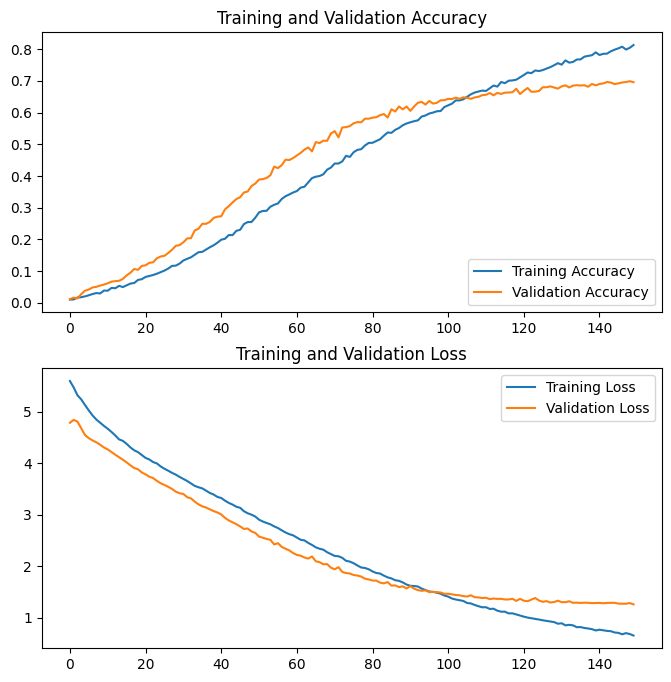

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
model.save('yuz_tanima_modeli_Aktramasiz.h5')

In [12]:
from tensorflow.keras.models import load_model

# Modeli yükle
model_yuklenen = load_model('yuz_tanima_modeli_Aktramasiz.h5')

In [13]:
import cv2
import numpy as np

def resmi_on_isle(path):
    # Resmi yükle
    img = cv2.imread(path)
    # Eğer resim yüklenemediyse None döndür
    if img is None:
        return None
    # Resmi griye çevir
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Resmi yeniden boyutlandır
    img_resized = cv2.resize(img_gray, (64, 64))
    # Resmi normalize et
    img_normalized = img_resized / 255.0
    # Resmi modelin beklediği forma dönüştür (1, 64, 64, 1)
    img_expanded = np.expand_dims(img_normalized, axis=[0, -1])
    return img_expanded

def resmi_tahmin_et(path, model):
    # Resmi ön işlemden geçir
    processed_img = resmi_on_isle(path)
    if processed_img is None:
        print("Resim yüklenemedi.")
        return
    # Tahmini yap
    prediction = model.predict(processed_img)
    # En yüksek tahmini bul
    predicted_class = np.argmax(prediction, axis=1)
    return predicted_class

with open('label_encoder.pkl', 'rb') as f:
    label_encoder = pickle.load(f)

# Kullanımı
resim_path = "105_classes_pins_dataset\pins_Anthony Mackie\Anthony Mackie8_551.jpg"
image = Image.open(resim_path).convert('RGB')
tahmin = resmi_tahmin_et(resim_path, model_yuklenen)
gercek_sinif = label_encoder.inverse_transform(tahmin)
# print(f"Tahmin edilen gerçek sınıf: {gercek_sinif[0]}")
plt.imshow(image)
plt.axis('off')  # Eksenleri kapat

# Tahmin edilen etiketi resmin üzerine yaz
# (10, 25) başlangıç konumunu belirtir. Bu değerleri ayarlayarak metnin pozisyonunu değiştirebilirsiniz.
plt.text(10, 25, gercek_sinif[0], color='white', fontsize=12, 
         bbox=dict(facecolor='red', alpha=0.5))

# Görseli göster
plt.show()


[ WARN:0@840.358] global loadsave.cpp:248 findDecoder imread_('105_classes_pins_dataset\pins_Eliza Taylor\Eliza Taylor33_823.jpg'): can't open/read file: check file path/integrity


Resim yüklenemedi.


ValueError: y should be a 1d array, got an array of shape () instead.